<a href="https://colab.research.google.com/github/wangleiphy/ml4p/blob/main/projects/alanine_dipeptide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Authors: [Lei Wang](mailto:wanglei@iphy.ac.cn) and [Zihang Li](mailto:lzh@iphy.ac.cn), Insitute of Physics, Chinese Academy of Sciences.

In [ ]:
# some necessary packages
!pip install -q dm-haiku # neural network library
!pip install -q optax    # optimization library   
!pip install -q pysmiles

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 KB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 KB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 KB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 KB 11.8 MB/s eta 0:00:00


In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
import haiku as hk
import optax
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import animation
from functools import partial
from pysmiles import read_smiles
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D

## Data

In [ ]:
!wget http://ftp.imp.fu-berlin.de/pub/cmb-data/alanine-dipeptide-3x250ns-heavy-atom-positions.npz

--2023-03-15 14:38:47--  http://ftp.imp.fu-berlin.de/pub/cmb-data/alanine-dipeptide-3x250ns-heavy-atom-positions.npz
Resolving ftp.imp.fu-berlin.de (ftp.imp.fu-berlin.de)... 160.45.117.8
Connecting to ftp.imp.fu-berlin.de (ftp.imp.fu-berlin.de)|160.45.117.8|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90000544 (86M)
Saving to: ‘alanine-dipeptide-3x250ns-heavy-atom-positions.npz’

alanine-dipeptide-3 100%[===================>]  85.83M  11.4MB/s    in 9.4s    

2023-03-15 14:38:57 (9.11 MB/s) - ‘alanine-dipeptide-3x250ns-heavy-atom-positions.npz’ saved [90000544/90000544]



In [ ]:
data = np.load('/content/alanine-dipeptide-3x250ns-heavy-atom-positions.npz')

In [ ]:
train_data, validation_data, test_data = data['arr_0'], data['arr_1'], data['arr_2']

In [ ]:
train_data.shape

(250000, 30)

There are 250000 configurations of alanine dipeptide in train_data.

In [ ]:
natoms = 10
dim = 3
train_data = train_data.reshape((-1, natoms, dim))

we fix the position of the first atom to be at the origin $(0,0,0)$

In [ ]:
train_data[0]

array([[ 0.1511757 ,  2.6883419 ,  0.21979772],
       [ 0.21478271,  2.59708   ,  0.11799731],
       [ 0.2634201 ,  2.6540673 ,  0.02176795],
       [ 0.22345658,  2.4659455 ,  0.1469564 ],
       [ 0.2779297 ,  2.370076  ,  0.05150771],
       [ 0.43110046,  2.342592  ,  0.08810053],
       [ 0.18788223,  2.244887  ,  0.0460969 ],
       [ 0.22003174,  2.1455202 , -0.02400756],
       [ 0.07149353,  2.2404244 ,  0.11968241],
       [-0.02181625,  2.1400998 ,  0.11392083]], dtype=float32)

In [ ]:
train_data -= train_data[:, None, 0]

In [ ]:
train_data[0]

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.06360702, -0.09126186, -0.1018004 ],
       [ 0.11224441, -0.03427458, -0.19802977],
       [ 0.07228088, -0.22239637, -0.07284132],
       [ 0.126754  , -0.31826591, -0.16829   ],
       [ 0.27992475, -0.34574986, -0.13169718],
       [ 0.03670654, -0.44345474, -0.17370081],
       [ 0.06885605, -0.54282165, -0.24380527],
       [-0.07968216, -0.44791746, -0.10011531],
       [-0.17299195, -0.5482421 , -0.10587689]], dtype=float32)

## Visualization

In [ ]:
smiles = 'CC(=O)NC(C)C(=O)NC' # SMILES for alanine dipeptide
mol = read_smiles(smiles)
elements = nx.get_node_attributes(mol, name = "element")
color_map = ['gray','gray','red','blue','gray','gray','gray','red','blue','gray']
L = 23.222 # box length in Angstrom https://markovmodel.github.io/mdshare/ALA2/#alanine-dipeptide

In [ ]:
def batch_plot(data):
    """
        Plot 10 molecules in data
    """
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6), subplot_kw={'xticks': [], 'yticks': [], 'zticks': [], 'projection': '3d'})
    for i, ax in enumerate(axes.flat):

        # 3d spring layout
        pos = dict(zip(range(10), data[i]*L))
     
        # Extract node and edge positions from the layout
        node_xyz = np.array([pos[v] for v in sorted(mol)])
        edge_xyz = np.array([(pos[u], pos[v]) for u, v in mol.edges()])

        # Plot the nodes - alpha is scaled by "depth" automatically
        ax.scatter(*node_xyz.T, s=150, ec="w", c=color_map)

        # Plot the edges
        for vizedge in edge_xyz:
            ax.plot(*vizedge.T, color="tab:gray")

    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    fig.legend(lines, labels)
    fig.tight_layout()

    # plt.close(fig)
    return fig

In [ ]:
def batch_anim(data,frames=180,interval=50,degree=2):
    """
        Make animation for 10 molecules in data
        Input:
            frames: number of frames in the animation
            interval: unit ms
            degree: degree of rotation per frame
    """
    fig = batch_plot(data)
    plt.close(fig)
    
    def animate(frame):
        for ax in fig.axes:
            ax.view_init(30, frame*degree)
            # plt.pause(.001)
        return fig

    anim = animation.FuncAnimation(fig, animate, frames=frames, interval=interval)
    return anim

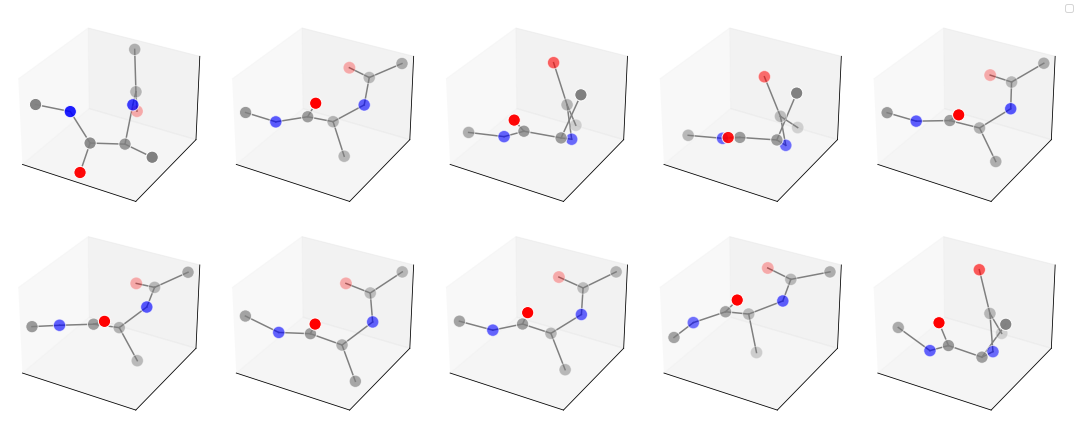

In [ ]:
fig = batch_plot(train_data)

In [ ]:
anim = batch_anim(train_data)
HTML(anim.to_html5_video())

# Model

In [ ]:
def make_transformer(key, n, dim, num_layers, num_heads, key_size):
   
    # read this to understand why we need these lines https://sjmielke.com/jax-purify.htm
    @hk.without_apply_rng
    @hk.transform
    def network(x): 
        assert x.ndim == 2  # (n, dim)
        n = x.shape[0]
        
        model_size = 2*dim # since we will predict mean and variance of atom position
        mask = jnp.tril(np.ones((1, n, n))) # mask for the attention matrix 

        initializer = hk.initializers.TruncatedNormal(0.01)
        h = hk.Linear(model_size, w_init=initializer)(x)
        for _ in range(num_layers):
            # https://github.com/deepmind/dm-haiku/blob/main/haiku/_src/attention.py 
            attn_block = hk.MultiHeadAttention(num_heads=num_heads, 
                                               key_size=key_size, 
                                               model_size=model_size,
                                               w_init = initializer
                                                )   
            h = attn_block(h, h, h, mask) + h

            dense_block = hk.Sequential([hk.Linear(4 * model_size, w_init=initializer),
                                         jax.nn.gelu,
                                         hk.Linear(model_size, w_init=initializer)]
                                         )
            h = dense_block(h) + h 
        
        mu, sigma = jnp.split(h, 2, axis=-1)
        sigma = jax.nn.softplus(sigma) # to ensure positivity
        h = jnp.concatenate([mu, sigma], axis=-1) 
        return h    
    
    x = jax.random.normal(key, (natoms, dim))
    params = network.init(key, x)
    return params, network.apply

In [ ]:
num_layers = 4
num_heads = 8
key_size = 16

key = jax.random.PRNGKey(42)
params, model = make_transformer(key, natoms, dim, num_layers, num_heads, key_size)

In [ ]:
from jax.flatten_util import ravel_pytree
ravel_pytree(params)[0].size # number of parameters in the model

15144

In [ ]:
model(params, train_data[0]).shape

(10, 6)

We can check that the model is indeed autoregressive

In [ ]:
def test_fn(x):
    outputs = model(params, x)
    return (outputs).sum(axis=-1)
jac = jax.jacfwd(test_fn)(train_data[0])
jac.shape

(10, 10, 3)

In [ ]:
jac = jnp.linalg.norm(jac, axis=-1)
(jac != 0.).astype(int)

Array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)

# Loss

For maximum likelihood estimation we minimize $$\mathcal{L} = -\mathop{\mathbb{E}}_{x\sim \mathrm{data}} \left[ \ln p(x)\right] $$

In [ ]:
def make_mle_loss(model):

    @partial(jax.vmap, in_axes=(None, 0), out_axes=0)
    def logp_fn(params, x):
        outputs = model(params, x)
        mu, sigma = jnp.split(outputs[:-1, :], 2, axis=-1) # until the last one 
        return jax.scipy.stats.norm.logpdf(x[1:, :], loc=mu, scale=sigma) # [1:] because we fix the first atom to be at 000

    def loss_fn(params, x):
        logp = logp_fn(params, x)
        return -jnp.mean(logp)
        
    return loss_fn

loss_fn = make_mle_loss(model)

In [ ]:
loss_fn(params, train_data[:5])

Array(0.6151335, dtype=float32)

# Optimization

In [ ]:
optimizer = optax.adam(1e-3)
opt_state = optimizer.init(params)

@jax.jit
def update(params, opt_state, data):
    value, grad = jax.value_and_grad(loss_fn)(params, data)
    updates, opt_state = optimizer.update(grad, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, value


In [ ]:
train_data = jax.random.permutation(key, train_data)
train_data = train_data[:10000] # to save time we use only 10000 of them to train

batchsize = 100
assert len(train_data)%batchsize==0

for epoch in range(100):
    key, subkey = jax.random.split(key)
    train_data = jax.random.permutation(subkey, train_data)

    total_loss = 0.0 
    counter = 0 
    for batch_index in range(0, len(train_data), batchsize):
        data = train_data[batch_index:batch_index+batchsize]
        key, subkey = jax.random.split(key)
        params, opt_state, loss = update(params, opt_state, data)
        total_loss += loss 
        counter += 1

    print(epoch, total_loss/counter) 


0 -0.41860503
1 -0.93589973
2 -1.0448242
3 -1.0992432
4 -1.1458231
5 -1.1697052
6 -1.1834632
7 -1.1967571
8 -1.2104547
9 -1.2264578
10 -1.2427555
11 -1.2577574
12 -1.2745942
13 -1.2967262
14 -1.3140877
15 -1.3328018
16 -1.3654225
17 -1.385222
18 -1.4268104
19 -1.4711004
20 -1.499709
21 -1.5398679
22 -1.5772483
23 -1.6003895
24 -1.6193063
25 -1.6584061
26 -1.6839437
27 -1.7254412
28 -1.7337419
29 -1.7626481
30 -1.782511
31 -1.8090003
32 -1.8053334
33 -1.840051
34 -1.841522
35 -1.8592236
36 -1.8786727
37 -1.8932116
38 -1.9008906
39 -1.9187669
40 -1.9380745
41 -1.9524815
42 -1.9613507
43 -1.978554
44 -1.9877789
45 -2.0114677
46 -2.0003488
47 -2.0379052
48 -2.0376945
49 -2.0599558
50 -2.0787833
51 -2.0828528
52 -2.0874684
53 -2.1026049
54 -2.1149504
55 -2.1385872
56 -2.1373575
57 -2.142144
58 -2.168804
59 -2.1773233
60 -2.1839352
61 -2.1905441
62 -2.185243
63 -2.2136862
64 -2.2173455
65 -2.2098703
66 -2.2335896
67 -2.2301052
68 -2.2473037
69 -2.2502785
70 -2.267432
71 -2.2684264
72 -2.2839

# Generate new samples

Now, we can try to sample from the trained model. First, remember the model predicts $\mu$ and $\sigma$ of Gaussian distribution.

In [ ]:
@jax.vmap
def inference(x): # here x can be data with various length
    outputs = model(params, x)
    mu, sigma = jnp.split(outputs[-1, :], 2, axis=-1) # only use the last one
    return mu, sigma

We sample in an autoregressive fashion: starting from atom 0 at the origin, then atom 1, then atom 2 ... 

In [ ]:
samples = jnp.zeros((batchsize, natoms, dim))
for i in range(1, natoms):
    mu, sigma = inference(samples[:, :i]) 
    key, subkey = jax.random.split(key)
    x = jax.random.normal(subkey, (batchsize, dim)) * sigma + mu
    samples = samples.at[:, i].set( x ) 

In [ ]:
samples[0]

Array([[ 0.        ,  0.        ,  0.        ],
       [-0.0911384 , -0.071728  , -0.10403522],
       [-0.21805862, -0.07052076, -0.09959866],
       [-0.05236069, -0.15447736, -0.15830974],
       [-0.13708715, -0.240403  , -0.28722352],
       [-0.0618098 , -0.30044684, -0.3708972 ],
       [-0.23061353, -0.3642577 , -0.17190523],
       [-0.19167033, -0.38665903, -0.074386  ],
       [-0.36595243, -0.3969953 , -0.19748634],
       [-0.4395665 , -0.5332788 , -0.16765623]], dtype=float32)

Have a look at generated sample

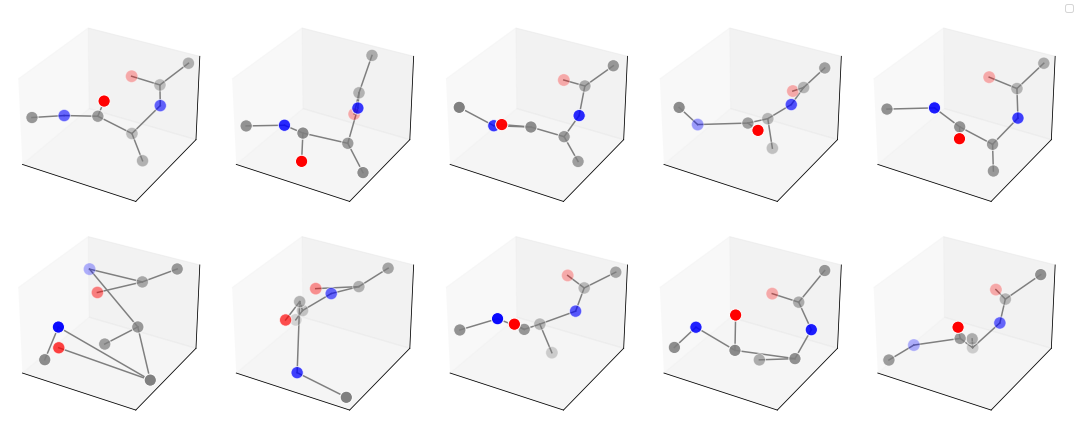

In [ ]:
batch_plot(samples)

In [ ]:
anim = batch_anim(samples)
HTML(anim.to_html5_video())